### A cell over two columns:
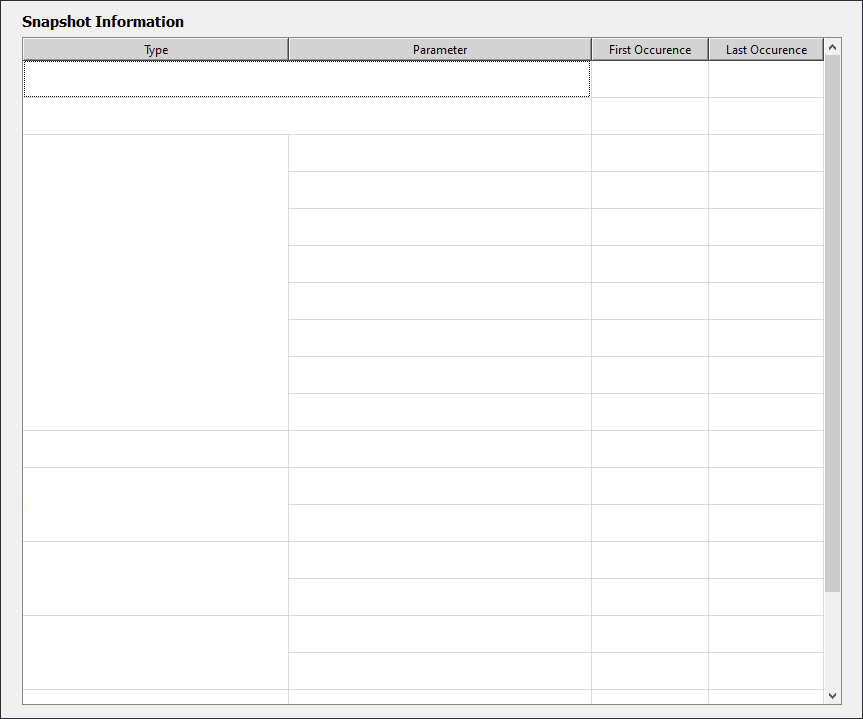

In [ ]:
class SnapshotInformationLayout(QVBoxLayout):
    """Vertical layout for snapshot information"""

    def __init__(self):
        super().__init__()
        titleLabel = QLabel("Snapshot Information")
        titleLabel.setStyleSheet("font-weight: bold; font-size: 15px;")
        self.snapshotTable = DTCTableWidget(SNAPSHOT_HEADER, [])
        self.snapshotTable.setRowCount(SNAPSHOT_ROW)
        self.snapshotTable.setColumnCount(SNAPSHOT_COLUMN)
        self.snapshotTable.setSortingEnabled(False)

        # add widgets
        self.addWidget(titleLabel)
        self.addWidget(self.snapshotTable)

        self.addParameterColumns()
        self.snapshotTable.resizeColumnsToContents()

        DTCSignals.UpdateSnapshotTable.connect(self.updateTable)

    def addParameterColumns(self):
        """Add fixed parameters to the columns."""
        rowIndex = 0
        col1 = 0
        col2 = 1
        for key, val in SNAPSHOT_COLUMN_ITEM.items():
            newItem = QTableWidgetItem(key)
            valLen = len(val)
            if valLen > 1:
                self.snapshotTable.setSpan(rowIndex, col1, valLen, 1)
            elif valLen == 1 and not val[0]:
                self.snapshotTable.setSpan(rowIndex, col1, 1, 2)
                newItem.setTextAlignment(Qt.AlignCenter)
            self.snapshotTable.setItem(rowIndex, col1, newItem)
            if valLen > 0:
                for i in val:
                    newItem = QTableWidgetItem(i)
                    self.snapshotTable.setItem(rowIndex, col2, newItem)
                    rowIndex += 1
            else:
                rowIndex += 1

    def updateTable(self, data: list):
        """Update data."""
        for index in range(SNAPSHOT_ROW):
            dt1 = data[0][index]
            dt2 = data[1][index]
            item1 = QTableWidgetItem(dt1)
            self.snapshotTable.setItem(index, 2, item1)
            item2 = QTableWidgetItem(dt2)
            self.snapshotTable.setItem(index, 3, item2)

### Dial and Slider with number labels

In [ ]:
"""
Valve position widget for displaying the current position of a valve and 
perform override operation.
"""

import sys

from PyQt5.QtCore import QEvent, QLineF, QRect, Qt, QTimer
from PyQt5.QtCore import pyqtSignal as Signal
from PyQt5.QtGui import QFont, QMouseEvent, QPainter, QPen
from PyQt5.QtWidgets import (QApplication, QDial, QDoubleSpinBox, QGroupBox, QLineEdit,
                             QHBoxLayout, QLabel, QSlider, QVBoxLayout,
                             QWidget)


class CustomDial(QWidget):
    """
    Below code is from: 
    https://stackoverflow.com/questions/63698714/how-to-show-markings-on-qdial-in-pyqt5-python

    This dial shows markings at every notch.
    """
    _dialProperties = ('minimum', 'maximum', 'value', 'singleStep', 'pageStep',
                       'notchesVisible', 'tracking', 'wrapping',
                       'invertedAppearance', 'invertedControls', 'orientation')
    _inPadding = 3
    _outPadding = 2
    valueChanged = Signal(int)

    def __init__(self, *args, **kwargs):
        # remove properties used as keyword arguments for the dial
        dialArgs = {k: v for k, v in kwargs.items()
                    if k in self._dialProperties}
        for k in dialArgs.keys():
            kwargs.pop(k)
        super().__init__(*args, **kwargs)
        layout = QVBoxLayout(self)
        self.dial = QDial(self, **dialArgs)
        layout.addWidget(self.dial)
        self.dial.valueChanged.connect(self.valueChanged)
        # make the dial the focus proxy (so that it captures focus *and* key events)
        self.setFocusProxy(self.dial)

        # simple "monkey patching" to access dial functions
        self.value = self.dial.value
        self.setValue = self.dial.setValue
        self.minimum = self.dial.minimum
        self.maximum = self.dial.maximum
        self.wrapping = self.dial.wrapping
        self.notchesVisible = self.dial.notchesVisible
        self.setNotchesVisible = self.dial.setNotchesVisible
        self.setNotchTarget = self.dial.setNotchTarget
        self.notchSize = self.dial.notchSize
        self.invertedAppearance = self.dial.invertedAppearance
        self.setInvertedAppearance = self.dial.setInvertedAppearance

        self.updateSize()

    def inPadding(self):
        return self._inPadding

    def setInPadding(self, padding):
        self._inPadding = max(0, padding)
        self.updateSize()

    def outPadding(self):
        return self._outPadding

    def setOutPadding(self, padding):
        self._outPadding = max(0, padding)
        self.updateSize()

    # the following functions are required to correctly update the layout
    def setMinimum(self, minimum):
        self.dial.setMinimum(minimum)
        self.updateSize()

    def setMaximum(self, maximum):
        self.dial.setMaximum(maximum)
        self.updateSize()

    def setWrapping(self, wrapping):
        self.dial.setWrapping(wrapping)
        self.updateSize()

    def updateSize(self):
        # a function that sets the margins to ensure that the value strings always
        # have enough space
        fm = self.fontMetrics()
        minWidth = max(fm.width(str(v))
                       for v in range(self.minimum(), self.maximum() + 1))
        self.offset = max(minWidth, fm.height()) / 2
        margin = round(self.offset + self._inPadding + self._outPadding)
        self.layout().setContentsMargins(margin, margin, margin, margin)

    def translateMouseEvent(self, event):
        # a helper function to translate mouse events to the dial
        return QMouseEvent(event.type(),
                           self.dial.mapFrom(self, event.pos()),
                           event.button(), event.buttons(), event.modifiers())

    def changeEvent(self, event):
        if event.type() == QEvent.FontChange:
            self.updateSize()

    def mousePressEvent(self, event):
        self.dial.mousePressEvent(self.translateMouseEvent(event))

    def mouseMoveEvent(self, event):
        self.dial.mouseMoveEvent(self.translateMouseEvent(event))

    def mouseReleaseEvent(self, event):
        self.dial.mouseReleaseEvent(self.translateMouseEvent(event))

    def paintEvent(self, event):
        radius = min(self.width(), self.height()) / 2
        radius -= (self.offset / 2 + self._outPadding)
        invert = -1 if self.invertedAppearance() else 1
        if self.wrapping():
            angleRange = 360
            startAngle = 270
            rangeOffset = 0
        else:
            angleRange = 300
            startAngle = 240 if invert > 0 else 300
            rangeOffset = 1
        fm = self.fontMetrics()

        # a reference line used for the target of the text rectangle
        reference = QLineF.fromPolar(
            radius, 0).translated(self.rect().center())
        fullRange = self.maximum() - self.minimum()
        textRect = QRect()

        qp = QPainter(self)
        qp.setRenderHints(qp.Antialiasing)
        # for p in range(0, fullRange + rangeOffset, self.notchSize()):
        for p in range(0, fullRange + rangeOffset, 1):
            value = self.minimum() + p
            if value % 10 == 0:
                if invert < 0:
                    value -= 1
                    if value < self.minimum():
                        continue
                angle = p / fullRange * angleRange * invert
                reference.setAngle(startAngle - angle)
                textRect.setSize(fm.size(Qt.TextSingleLine, str(value)))
                textRect.moveCenter(reference.p2().toPoint())
                qp.drawText(textRect, Qt.AlignCenter, str(value))


class CustomVerticalSlider(QSlider):
    """Custom vertical slider with tick marks and labels."""
    trackClicked = Signal() # when click on track emit the signal
    """
    use sliderReleased and trackClicked to emit signal to indicate valve
    has been changed. valueChange emits everytime the slider value changes,
    which is too many times.
    """

    def __init__(self, min_value: int, max_value: int, parent=None):
        super().__init__(Qt.Vertical, parent)
        self.setMinimum(min_value)
        self.setMaximum(max_value)
        self.majorTickInterval = 20
        self.minorTickInterval = 2
        self.setTickPosition(QSlider.NoTicks)
        self.setMinimumWidth(100)
        # self.setMinimumHeight(180)
        self.setFixedHeight(600)
        self.setStyleSheet(
            """
                QSlider {
                    padding: 20px;
                }
                QSlider::groove:vertical {
                    background: lightgray;
                    border: 1px solid gray;
                    width: 3px;
                    border-radius: 2px;
                }
                QSlider::handle:vertical {
                    background: #1e90ff;
                    border: 1px solid black;
                    height: 12px;
                    margin: 0px -4px;
                    border-radius: 5px;
                }
            """
        )

    def paintEvent(self, event):
        painter = QPainter(self)
        painter.setPen(QPen(Qt.black))
        painter.setFont(QFont("Arial", 8))

        margin = 25
        available_height = self.height() - 2 * margin
        left = 40

        # Draw ticks and labels
        for value in range(self.minimum(), self.maximum() + 1, self.minorTickInterval):
            ratio = (value - self.minimum()) / \
                (self.maximum() - self.minimum())
            y = self.height() - margin - ratio * available_height

            if value % self.majorTickInterval == 0:
                tick_len = 5
                painter.setPen(QPen(Qt.black, 2))
                painter.drawLine(left, int(y), left + tick_len, int(y))
                painter.drawText(left - 30, int(y - 8), 20,
                                 20, Qt.AlignRight, str(value))
            else:
                tick_len = 4
                painter.setPen(QPen(Qt.gray, 1))
                painter.drawLine(left + 5, int(y), left + 5 + tick_len, int(y))

        return super().paintEvent(event)

    def mousePressEvent(self, event):
        if event.button() == Qt.LeftButton:
            # Calculate value based on Y click position
            click_y = event.y() - 25
            slider_height = self.height() - 50
            slider_min = self.minimum()
            slider_max = self.maximum()
            # Invert Y to match slider logic
            val = slider_min + ((slider_max - slider_min)
                                * (slider_height - click_y) / slider_height)
            val = int(round(val))
            # Set and emit
            self.setValue(val)
            self.trackClicked.emit()
        super().mousePressEvent(event)


class ControlPanel(QWidget):
    """ Control Panel with Dial and Slider for Position Control.
    """
    MINIMUM = 0
    MAXIMUM = 127.5

    def __init__(self):
        super().__init__()
        self.setWindowTitle("Industrial Control Panel")
        # self.setMinimumSize(400, 300)

        layout = QHBoxLayout()

        # control valve position dial
        overrideGroup = QGroupBox("Position Override")
        overrideVLayout = QVBoxLayout()
        overrideGroup.setLayout(overrideVLayout)
        overrideGroup.setCheckable(True)
        overrideGroup.setChecked(True)

        self.overrideInput = QDoubleSpinBox()
        self.overrideInput.setRange(self.MINIMUM, self.MAXIMUM)
        self.overrideInput.setSingleStep(1)
        self.overrideInput.setDecimals(1)
        self.overrideInput.setSuffix(" %")
        self.overrideInput.setStyleSheet(
            """
            QDoubleSpinBox {
                font-size: 10pt;
                color: black;
            }
            """
        )
        self.overrideInput.editingFinished.connect(self.updateDial)

        self.dial = CustomDial(minimum=self.MINIMUM,
                               maximum=round(self.MAXIMUM))
        self.dial.setNotchesVisible(True)
        self.dial.valueChanged.connect(self.updateOverrideInput)

        overrideVLayout.addWidget(self.overrideInput)
        overrideVLayout.addWidget(self.dial)

        # actual valve position slider
        valueGroup = QGroupBox("Actual Position")
        valueVLayout = QVBoxLayout()
        valueGroup.setLayout(valueVLayout)

        self.actualLineEdit = QLineEdit()
        self.actualLineEdit.setReadOnly(True)
        self.actualLineEdit.setStyleSheet(
            """
            QLineEdit {
                font-size: 10pt;
            }
            """
        )

        self.slider = CustomVerticalSlider(self.MINIMUM, round(self.MAXIMUM))
        self.slider.setDisabled(True)

        valueVLayout.addWidget(self.actualLineEdit)
        valueVLayout.addWidget(self.slider, alignment=Qt.AlignCenter)

        layout.addWidget(overrideGroup)
        layout.addWidget(valueGroup)
        self.setLayout(layout)

        # Simulate actual position tracking toward setpoint
        self.timer = QTimer()
        self.timer.timeout.connect(self.simulateFeedback)
        # self.timer.start(10)

        self.actualPosition = 0.0

    def closeEvent(self, a0):
        # stop timer when closing the window
        self.timer.stop()
        return super().closeEvent(a0)

    def updateOverrideInput(self, value):
        """While the dial is being turned, update the override input."""
        self.overrideInput.blockSignals(True)
        self.overrideInput.setValue(value)
        self.overrideInput.blockSignals(False)

        self.actualPosition = value

        # TODO
        self.slider.setValue(value)
        self.actualLineEdit.setText(f"{value} %")

    def updateDial(self):
        """While the override input is being changed, update the dial."""
        actual = self.overrideInput.value()
        value = round(actual)
        self.dial.blockSignals(True)
        self.dial.setValue(value)
        self.dial.blockSignals(False)

        self.actualPosition = actual

        # TODO
        self.slider.setValue(value)
        self.actualLineEdit.setText(f"{actual} %")

    def simulateFeedback(self):
        """Simulate actual value moving slowly toward setpoint"""
        current = self.slider.value()
        target = self.overrideInput.value()
        if current == target:
            return
        elif current < target:
            if target - current < 1:
                current = target
            else:
                current += 1
        else:
            if current - target < 1:
                current = target
            else:
                current -= 1

        self.slider.setValue(round(current))
        self.actualLineEdit.setText(f"{current} %")
        # # color feedback
        # color = "green" if current > 70 else "orange" if current > 30 else "red"
        # self.actualLineEdit.setStyleSheet(f"font-size: 10pt; color: {color};")


if __name__ == "__main__":
    app = QApplication(sys.argv)
    win = ControlPanel()
    win.show()
    sys.exit(app.exec_())

## Custom vertical bar chart

In [ ]:

class VerticalBarWidget(QWidget):
    def __init__(self, min_val: int, max_val: int, value: float | int = 0, parent=None):
        super().__init__(parent)
        self.min_val = min_val
        self.max_val = max_val
        self.value = value
        self.setMinimumSize(100, 500)
        self.setContentsMargins(0, 0, 0, 0)

    def setValue(self, value):
        self.value = max(self.min_val, min(self.max_val, value))
        self.update()

    def paintEvent(self, event):
        painter = QPainter(self)
        painter.setRenderHint(QPainter.Antialiasing)

        margin = 20
        bar_width = 30
        label_spacing = 40

        bar_rect = QRect(
            margin + label_spacing,
            margin,
            bar_width,
            self.height() - 2 * margin
        )

        # Draw background bar
        painter.setPen(Qt.black)
        painter.setBrush(QColor(230, 230, 230))  # light gray
        painter.drawRect(bar_rect)

        # Draw filled value bar
        fill_ratio = (self.value - self.min_val) / \
            (self.max_val - self.min_val)
        fill_height = int(fill_ratio * bar_rect.height())
        fill_rect = QRect(
            bar_rect.left(),
            bar_rect.bottom() - fill_height,
            bar_rect.width(),
            fill_height
        )
        painter.setBrush(QColor(30, 70, 180))  # dark blue fill
        painter.drawRect(fill_rect)

        # Draw number labels on the left
        painter.setPen(Qt.black)
        painter.setFont(QFont("Arial", 8))
        step = 10
        for v in range(self.min_val, self.max_val + 1, step):
            y = bar_rect.bottom() - int((v - self.min_val) /
                                        (self.max_val - self.min_val) * bar_rect.height())
            painter.drawText(margin, y + 4, str(v))
